In [1]:
%matplotlib inline


# Example: Predator-Prey Model

This example replicates the great case study [1], which leverages the Lotka-Volterra
equation [2] to describe the dynamics of Canada lynx (predator) and snowshoe hare
(prey) populations. We will use the dataset obtained from [3] and run MCMC to get
inferences about parameters of the differential equation governing the dynamics.

**References:**

    1. Bob Carpenter (2018), `"Predator-Prey Population Dynamics: the Lotka-Volterra model in Stan"
       <https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html/>`_.
    2. https://en.wikipedia.org/wiki/Lotka-Volterra_equations
    3. http://people.whitman.edu/~hundledr/courses/M250F03/M250.html

<img src="file://../_static/img/examples/ode.png" align="center">


1


sample: 100%|██████████| 2000/2000 [00:07<00:00, 252.71it/s, 7 steps of size 4.03e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      1.04      0.08      1.04      0.93      1.18    830.36      1.00
  sigma[1]      0.77      0.05      0.76      0.69      0.86   1034.16      1.00
  theta[0]      0.80      0.24      0.77      0.39      1.13    796.39      1.00
  theta[1]      0.04      0.01      0.03      0.02      0.05    770.74      1.00
  theta[2]      0.43      0.14      0.40      0.23      0.62    686.91      1.00
  theta[3]      0.01      0.01      0.01      0.01      0.02    717.58      1.00
 z_init[0]     17.75      3.45     17.24     12.48     23.18    620.09      1.00
 z_init[1]     29.31      4.28     29.06     21.86     35.10    776.35      1.00

Number of divergences: 2


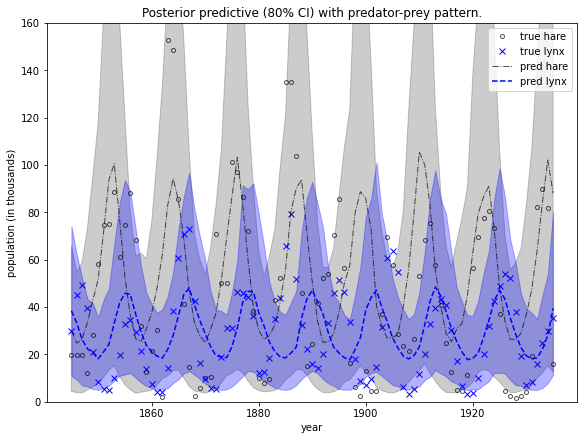

In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt

import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

#matplotlib.use("Agg")  # noqa: E402


def dz_dt(z, t, theta):
    """
    Lotka–Volterra equations. Real positive parameters `alpha`, `beta`, `gamma`, `delta`
    describes the interaction of two species.
    """
    u = z[0]
    v = z[1]
    alpha, beta, gamma, delta = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
    )
    du_dt = (alpha - beta * v) * u
    dv_dt = (-gamma + delta * u) * v
    return jnp.stack([du_dt, dv_dt])


def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    # measurement times
    ts = jnp.arange(float(N))
    # parameters alpha, beta, gamma, delta of dz_dt
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 0.05, 1.0, 0.05]),
            scale=jnp.array([0.5, 0.05, 0.5, 0.05]),
        ),
    )
    # integrate dz/dt, the result will have shape N x 2
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    # measurement errors
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    # measured populations
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)


def main(args):
    _, fetch = load_dataset(LYNXHARE, shuffle=False)
    year, data = fetch()  # data is in hare -> lynx order

    # use dense_mass for better mixing rate
    mcmc = MCMC(
        NUTS(model, dense_mass=True),
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(PRNGKey(1), N=data.shape[0], y=data)
    mcmc.print_summary()

    # predict populations
    pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
    mu = jnp.mean(pop_pred, 0)
    pi = jnp.percentile(pop_pred, jnp.array([10, 90]), 0)
    plt.figure(figsize=(8, 6), constrained_layout=True)
    plt.plot(year, data[:, 0], "ko", mfc="none", ms=4, label="true hare", alpha=0.67)
    plt.plot(year, data[:, 1], "bx", label="true lynx")
    plt.plot(year, mu[:, 0], "k-.", label="pred hare", lw=1, alpha=0.67)
    plt.plot(year, mu[:, 1], "b--", label="pred lynx")
    plt.fill_between(year, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
    plt.fill_between(year, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
    plt.gca().set(ylim=(0, 160), xlabel="year", ylabel="population (in thousands)")
    plt.title("Posterior predictive (80% CI) with predator-prey pattern.")
    plt.legend()

    plt.savefig("ode_plot.pdf")


if __name__ == "__main__":
    
    
    assert numpyro.__version__.startswith("0.9.0")
    
    class Args:
        num_samples = int(1e3)
        num_warmup = int(1e3)
        num_chains = int(1)
        device = "cpu"

    args = Args()

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)
    print(jax.local_device_count())
    main(args)

[[ 1.00000001e-07  1.00000005e-03  2.83299997e-08  2.12500009e-08
   2.83299997e-08  2.83299997e-08  2.12500009e-08  2.12500009e-08
   2.12500009e-08  2.83299997e-08]
 [ 9.76457102e-08  1.00000005e-03  2.57524970e-08  1.86712867e-08
   3.08473922e-08  2.83914030e-08  2.13101075e-08  2.37677593e-08
   2.12500009e-08  2.83299997e-08]
 [ 9.55909059e-08  1.00000005e-03  2.31722836e-08  1.60873235e-08
   3.33882397e-08  2.84344726e-08  2.13495266e-08  2.60268589e-08
   2.12500009e-08  2.83299997e-08]
 [ 9.38362916e-08  1.00000005e-03  2.05910631e-08  1.34998110e-08
   3.59482080e-08  2.84619279e-08  2.13712728e-08  2.80271095e-08
   2.12500009e-08  2.83299997e-08]
 [ 9.23812777e-08  1.00000005e-03  1.80103257e-08  1.09102238e-08
   3.85235666e-08  2.84761974e-08  2.13779430e-08  2.97683762e-08
   2.12500009e-08  2.83299997e-08]
 [ 9.12258642e-08  1.00000005e-03  1.54312882e-08  8.31975289e-09
   4.11108907e-08  2.84793380e-08  2.13718074e-08  3.12506181e-08
   2.12500009e-08  2.83299997e-08

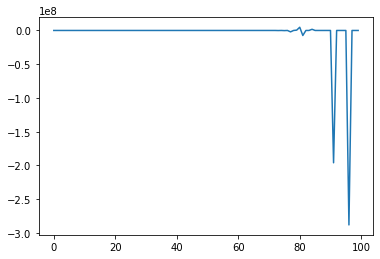

In [18]:
# full transporter model


# vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
# vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
# vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
# vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
# vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
# vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
# vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
# vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
# vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
# vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
# vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
# vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

# dOF/dt = vrxn1 - vrxn2 + vrxn3
# dOF_Hb/dt = vrxn2 - vrxn4 + vrxn5
# dIF_Hb/dt = vrxn4 - vrxn9 - vrxn11
# dS_in/dt = -vrxn10 - vrxn11
# dIF_Hb_Sb/dt = vrxn8 + vrxn11 - vrxn12
# dH_in/dt = vrxn9 + vrxn12
# dIF_Sb/dt = -vrxn6 + vrxn10 + vrxn12
# dOF_Sb/dt = -vrxn3 + vrxn6 - vrxn7
# dIF/dt = -vrxn1 + vrxn9 - vrxn10
# dOF_Hb_Sb/dt = -vrxn5 + vrxn7 - vrxn8


def transporter_1c(z, t, theta, b):
    "single cycle 1:1 alternating access antiporter model"

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0
    rxn1_k2 = 0
    rxn2_k1 = 10**theta[..., 0]
    rxn2_k2 = 10**theta[..., 1]
    rxn3_k1 = 10**theta[..., 2]
    rxn3_k2 = 10**theta[..., 3]
    rxn4_k1 = 10**theta[..., 4]
    rxn4_k2 = 10**theta[..., 5]
    rxn5_k1 = 0
    rxn5_k2 = 0
    rxn6_k1 = 10**theta[..., 6]
    rxn6_k2 = 10**theta[..., 7]
    rxn7_k1 = 0
    rxn7_k2 = 0
    rxn8_k1 = 0
    rxn8_k2 = 0
    rxn9_k1 = 0
    rxn9_k2 = 0
    rxn10_k1 = 0
    rxn10_k2 = 0
    rxn11_k1 = 10**theta[..., 8]
    rxn11_k2 = 10**theta[..., 9]
    rxn12_k1 = 10**theta[..., 10]

    
    # cycle constraint
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)

    ### volume size (in L)
    vol = 0.0001  

    ### populations (in M)
    H_out = b[0]  # constant buffer solution 
    S_out = b[1]  # constant buffer solution
    H_in = z[0]
    S_in = z[1]
    OF = z[2]
    IF = z[3]
    OF_Hb = z[4]
    IF_Hb = z[5]
    OF_Sb = z[6]
    IF_Sb = z[7]
    OF_Hb_Sb = z[8]
    IF_Hb_Sb = z[9]
           
    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations
    dOF_dt = vrxn1 - vrxn2 + vrxn3
    dOF_Hb_dt = vrxn2 - vrxn4 + vrxn5
    dIF_Hb_dt = vrxn4 - vrxn9 - vrxn11
    dS_in_dt = -vrxn10 - vrxn11
    dIF_Hb_Sb_dt = vrxn8 + vrxn11 - vrxn12
    dH_in_dt = vrxn9 + vrxn12
    dIF_Sb_dt = -vrxn6 + vrxn10 + vrxn12
    dOF_Sb_dt = -vrxn3 + vrxn6 - vrxn7
    dIF_dt = -vrxn1 + vrxn9 - vrxn10
    dOF_Hb_Sb_dt = -vrxn5 + vrxn7 - vrxn8
    
    ODE_list = [
        dOF_dt,
        dOF_Hb_dt, 
        dIF_Hb_dt,
        dS_in_dt,
        dIF_Hb_Sb_dt,
        dH_in_dt,
        dIF_Sb_dt,
        dOF_Sb_dt,
        dIF_dt,
        dOF_Hb_Sb_dt,
    ]
    return jnp.stack(ODE_list)
    
    

### initial populations
z0 = jnp.array([
    1e-7,
    1e-3,
    2.833e-8,
    2.125e-08,
    2.833e-8,
    2.833e-8,
    2.125e-08,
    2.125e-08,
    2.125e-08,
    2.833e-8,
])


### buffer solutions (H_out and S_out concentrations)
b0 = jnp.array([1e-07, 0.001])
b1 = jnp.array([5e-08, 0.001])
b2 = jnp.array([1e-07, 0.001])

### measurement times
tm = jnp.linspace(0,10,100)

# parameters alpha, beta, gamma, delta of dz_dt
# theta = numpyro.sample(
#     "theta",
#     dist.TruncatedNormal(
#         low=0.0,
#         loc=jnp.array([1.0, 0.05, 1.0, 0.05]),
#         scale=jnp.array([0.5, 0.05, 0.5, 0.05]),
#     ),
# )


### rate constants
log_k_H_on = jnp.log10(1e10)
log_k_H_off = jnp.log10(1e3)
log_k_S_on = jnp.log10(1e7)
log_k_S_off = jnp.log10(1e3)
log_k_conf = jnp.log10(1e2)

theta = jnp.array([
    log_k_H_on,
    log_k_H_off,
    log_k_S_off,
    log_k_S_on,
    log_k_conf,
    log_k_conf,
    log_k_conf,
    log_k_conf,
    log_k_S_on,  
    log_k_S_off,  
    log_k_H_off,  
])

# integrate 
s0 = odeint(transporter_1c, z0, tm, theta, b0, rtol=1e-17, atol=1e-19, mxstep=1000)
s1 = odeint(transporter_1c, s0[-1], tm, theta, b1, rtol=1e-17, atol=1e-19, mxstep=1000)
s2 = odeint(transporter_1c, s1[-1], tm, theta, b2, rtol=1e-17, atol=1e-19, mxstep=1000)

vol = 0.0001
rxn12_k1 = 
rxn12_k2 = (theta[0]*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)

ion_flux = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)



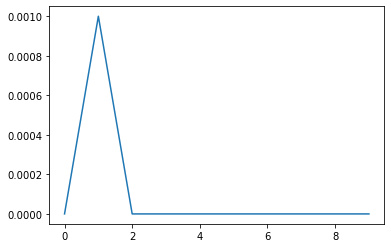